In [1]:
%load_ext autoreload
%autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", "external/local_xla/xla/")
warnings.filterwarnings("ignore", "TensorRT")
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import tensorflow as tf
import numpy as np
import scipy, h5py
import matplotlib.pyplot as plt
from copy import deepcopy
import crc
import json
import random
import keras

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

from sklearn import preprocessing

2024-02-16 12:00:36.681246: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 12:00:37.974292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 12:00:37.974402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 12:00:38.079188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 12:00:38.153002: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Colours
r = lambda: random.randint(0,255)
complimentary_hex = lambda my_hex : '#' + ''.join(['%02X' % (255 - int(a, 16)) for a in (my_hex[1:3], my_hex[3:5], my_hex[5:7])])
og_hex = '#%02X%02X%02X' % (r(),r(),r())
rc_hex = complimentary_hex(og_hex)

In [4]:
MODE          = '2,2' 
MODE_tag      = MODE.replace(',', '_')
COMPONENT     = 'phi'
COMPONENTS    = ['full', 'A', 'phi']
COMPONENT_obj = COMPONENTS.index(COMPONENT)
# N             = 3 # 65,536
# N             = 2 # 10,000
N             = 0 # 1,000
N_test        = 1 # 1,000
SPIN          = False
CONDITIONING  = True

In [5]:
_, time_indexes, B, _ = crc.load_bits(MODE, COMPONENT, N)
time = np.linspace(-5000, 250, 5251)
T = time[time_indexes]

In [6]:
x_data, y_data = crc.load_dataset_spinless(MODE, COMPONENT, N, time_indexes)
yscaler = preprocessing.MinMaxScaler()
yscaler.fit(y_data)
if CONDITIONING:
    y_data = yscaler.transform(y_data)
print(f'x_data shape : {x_data.shape} | y_data shape : {y_data.shape}')

train_x, test_x, train_y, test_y = crc.train_test_split(x_data, y_data, fraction_train=0.8, spin=False, shuffle=True)

x_data shape : (1000, 3) | y_data shape : (1000, 34)


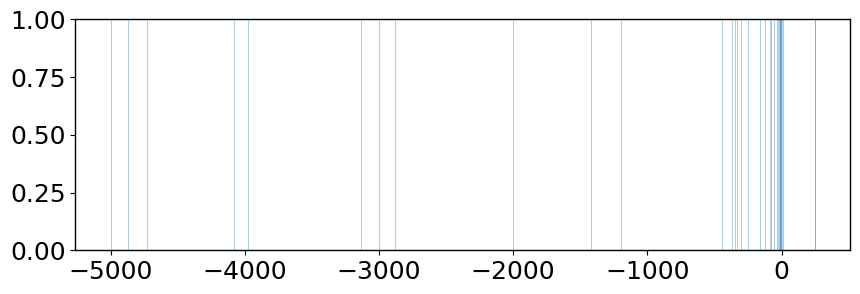

In [8]:
# plot empirical time nodes
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# for wf in y_data:
#     plt.plot([a[0] for a in sorted(zip(T, wf))], [a[1] for a in sorted(zip(T, wf))])
for node in T:
    plt.axvline(node, linewidth=0.5, alpha=0.5)

In [9]:
# activations = [
#     'elu', 'exponential', 'gelu', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'swish', 'tanh'
# ]

In [10]:
# ### AMPLITUDE (2,2) ###
# # construct ANN

# # N_epochs
# Ns = [200, 300, 150]
# Ne = Ns[0]

# # initial_lr
# lr0s = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
# lr0  = lr0s[0]

# # minimum lr
# lr_min_ = [1e-5]
# lr_min  = lr_min_[0]

# # lr on plateau patience
# lrop_patience_ = [12, 10, 8, 6, 4, 14, 16]
# lrop_patience  = lrop_patience_[0]

# # early stopping
# es_patience = 2 * lrop_patience

# # batch size
# bs = 16

# # Adam optimiser
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr0, epsilon=1e-6, name='Adam')

# # stop model learning if no improvement for extended period
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=es_patience, verbose=1, restore_best_weights=True)

# # reduce learning rate on plateau
# lrop_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=lrop_patience, min_lr=lr_min, verbose=1)

# # construct model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(32, activation='gelu', input_shape=(x_data.shape[1] if SPIN else 1,)),
#     tf.keras.layers.Dense(64, activation='softplus'),
#     tf.keras.layers.Dense(y_data.shape[1], activation='linear', bias_initializer=tf.keras.initializers.glorot_uniform)
# ])

# # Loss function we want to use is the mean square error. Compare to the loss function used in classification.
# model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

In [118]:
### PHASE (2,2) ###
# construct ANN

# N_epochs
Ns = [200, 100, 450]
Ne = Ns[0]
ne = int(Ne)

# initial_lr
lr0_ = [1e-2, np.pi/180, 5e-2, 1e-1, 1e-3, 1, 2**-6, 0.007/5, 0.007*5]
lr0  = lr0_[-3]

# minimum lr
lr_min_ = [1e-5, 1e-10, 1e-15, 1e-20]
lr_min  = lr_min_[-1]

# lr on plateau patience
lrop_patience_ = [12, 6, 3, 2, 24]
lrop_patience  = lrop_patience_[0]

# lr on plateau factor
lrop_factor_ = [0.5, 0.25, 0.75, 0.85, 0.95]
lrop_factor  = lrop_factor_[2]

# early stopping
es_patience = int(3 * lrop_patience)

# batch size
bs = 32

# Adam optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=lr0, epsilon=1e-6, name='Adam')

# stop model learning if no improvement for extended period
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=es_patience, verbose=1, restore_best_weights=True)

# reduce learning rate on plateau
lrop_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lrop_factor, patience=lrop_patience, min_lr=lr_min, verbose=1)

# construct model
model = tf.keras.Sequential([
    # tf.keras.layers.Dense(16, activation='gelu', input_shape=(x_data.shape[1] if SPIN else 1,)),
    tf.keras.layers.Dense(8, activation='softmax', input_shape=(x_data.shape[1] if SPIN else 1,)),
    tf.keras.layers.Dense(64, activation='swish'),
    # tf.keras.layers.Dense(16, activation='softmax'),
    # tf.keras.layers.Dense(16, activation='softmax'),
    # tf.keras.layers.Dense(16, activation='softmax'),
    # tf.keras.layers.Dense(16, activation='softmax'),
    # tf.keras.layers.Dense(16, activation='softmax'),
    # tf.keras.layers.Dense(16, activation='tanh'),
    # tf.keras.layers.Dense(16, activation='sigmoid'),
    # tf.keras.layers.Dense(16, activation='softplus'),
    tf.keras.layers.Dense(y_data.shape[1], activation='linear', bias_initializer=tf.keras.initializers.glorot_uniform)
])

# Loss function we want to use is the mean square error. Compare to the loss function used in classification.
model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

In [119]:
# train model
history = model.fit(
    train_x, train_y, validation_data = (test_x, test_y), 
    epochs=Ne, batch_size=bs, shuffle=True, callbacks=[
        # early_stopping,
        lrop_callback
    ]
)

model.summary()

Epoch 1/200
25/25 [==============================] - 1s 7ms/step - loss: 0.1062 - mae: 0.2603 - mse: 0.1062 - val_loss: 0.0196 - val_mae: 0.1066 - val_mse: 0.0196 - lr: 0.0156
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0123 - mae: 0.0784 - mse: 0.0123 - val_loss: 0.0085 - val_mae: 0.0581 - val_mse: 0.0085 - lr: 0.0156
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0078 - mae: 0.0556 - mse: 0.0078 - val_loss: 0.0074 - val_mae: 0.0506 - val_mse: 0.0074 - lr: 0.0156
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0511 - mse: 0.0072 - val_loss: 0.0092 - val_mae: 0.0660 - val_mse: 0.0092 - lr: 0.0156
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0534 - mse: 0.0074 - val_loss: 0.0079 - val_mae: 0.0541 - val_mse: 0.0079 - lr: 0.0156
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0503 - mse: 0.0072 - val_loss: 

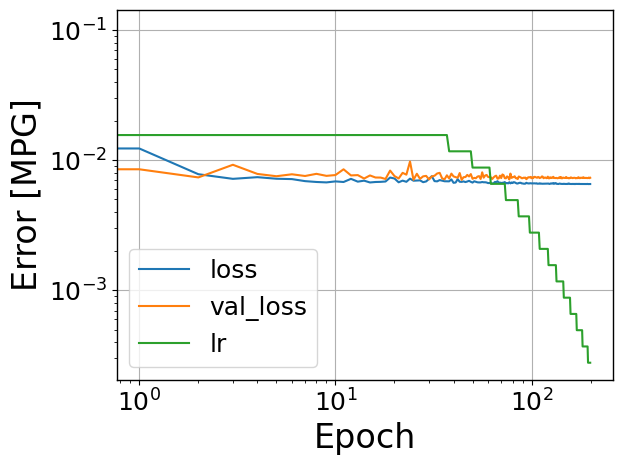

In [120]:
plt.loglog(history.history['loss']    , label='loss')
plt.loglog(history.history['val_loss'], label='val_loss')
plt.loglog(history.history['lr']      , label='lr')
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [14]:
# model.save(f'../models/spinless_{MODE_tag}_{COMPONENT}.keras')
# model = keras.models.load_model(f'../models/spinless_{MODE_tag}_{COMPONENT}.keras')
# model.summary()

In [15]:
# crc.pTpeline_spinless(MODE, COMPONENT)

In [16]:
test_waveforms = crc.add_A_phi(crc.load_waveforms(MODE, N_test, spin=False, aligned=False))
A_test         = crc.reformat(test_waveforms, 'q')[COMPONENT_obj][MODE]

In [17]:
# x_data_test, y_data_test = crc.load_dataset_spinless(MODE, COMPONENT, N_test, time_indexes)
x_data_test, y_data_test = x_data, y_data
if CONDITIONING:
    predict_y   = yscaler.inverse_transform(model.predict(x_data_test[:, :1]))
elif not CONDITIONING:
    predict_y = model.predict(x_data_test[:, :1])

313/313 [==============================] - 0s 1ms/step


In [18]:
reconstructed_amplitudes = np.zeros((len(A_test), len(time)))
for i, q in zip([i for i in range(len(A_test))], [float(q) for q in A_test]):
    h                            = predict_y[i]
    # h                            = y_data_test[i]
    Ih                           = crc.EI_h(h, B, time_indexes)
    reconstructed_amplitudes[i] += Ih

In [19]:
# calculate mse
mse = (np.square(predict_y - y_data_test)).mean(axis=1)
ind = np.where(np.max(np.abs(mse)) == mse)[0][0]
print(f'ind: {ind} | mse: {mse[ind]:.3f} | mismatch: 10^({np.log10(crc.mismatch(reconstructed_amplitudes[ind], A_test[list(A_test.keys())[ind]])):.3f})')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # calculate mse                                                                              │
│   2 mse = (np.square(predict_y - y_data_test)).mean(axis=1)                                      │
│   3 ind = np.where(np.max(np.abs(mse)) == mse)[0][0]                                             │
│ ❱ 4 print(f'ind: {ind} | mse: {mse[ind]:.3f} | mismatch: 10^({np.log10(crc.mismatch(reconstr     │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 9999 is out of bounds for axis 0 with size 1000

In [ ]:
# # plot mse
# fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# ax.plot([i for i in range(mse.shape[0])], mse)
# fig.tight_layout()

In [ ]:
# plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot([a[0] for a in sorted(zip(T, A_test[list(A_test.keys())[ind]][time_indexes]))],
        [a[1] for a in sorted(zip(T, A_test[list(A_test.keys())[ind]][time_indexes]))], 
        color=og_hex, label = "Original", zorder=0)
ax.plot([a[0] for a in sorted(zip(T, predict_y[ind]))], 
        [a[1] for a in sorted(zip(T, predict_y[ind]))], 
        color=rc_hex, label = "Neural Network", zorder=1, linestyle="dashed")
for node in T:
    ax.axvline(node, linewidth=0.5, alpha=0.5)
    plt.annotate
fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(time, crc.matrix_basis(A_test)[ind], color=og_hex, label = "Original", zorder=0)
ax.plot(time, reconstructed_amplitudes[ind], color=rc_hex, label = "Neural Network", zorder=1, linestyle="dashed")
for node in T:
    ax.axvline(node, linewidth=0.5, alpha=0.5)
    plt.annotate
ax.set_xlim(-50, 50)
fig.tight_layout()

In [ ]:
## mismatches = []
# for i in range(reconstructed_amplitudes.shape[0]):
#     mismatch = crc.mismatch(reconstructed_amplitudes[i], A_test[list(A_test.keys())[i]])
#     mismatches.append(mismatch)
# mismatches = np.array(mismatches)
# print(np.max(mismatches))

In [ ]:
# temp = []
# max = []
# min = []
# for i, mm in enumerate(mismatches):
#     temp.append(mm)
#     if np.argmax(temp) == i:
#         max.append(i)
#     if np.argmin(temp) == i:
#         min.append(i)

# maxima = []
# for i, ma in enumerate(max[:-1]):
#     if np.abs(ma - max[i+1]) > 10:
#         maxima.append(ma)
# maxima.append(max[-1]) 
# maxima = np.array(maxima)

# minima = []
# for i, mi in enumerate(min[:-1]):
#     if np.abs(mi - min[i+1]) > 10:
#         minima.append(mi)       
# minima.append(min[-1])
# minima = np.array(minima)

# # print(max)
# # print(min)

In [ ]:
# plt.loglog([q for q in A_test.keys()], mismatches)
# plt.scatter(x_data_test[maxima, 0], mismatches[maxima], marker='x', color='r')
# plt.scatter(x_data_test[minima, 0], mismatches[minima], marker='x', color='g')

In [ ]:
# fig, axs = plt.subplots(len(maxima), 1, figsize=(10, 3*len(maxima)))
# for i, mm in enumerate(maxima):
#     axs[i].scatter(T, predict_y[mm], marker='x')
#     axs[i].plot(time, crc.matrix_basis(A_test)[mm])